# Effective quantum transport simulations with Kwant


<img src="images/kwant-logo.png"> </img>

### Follow along in your browser: http://tiny.cc/maryland-tutorial

<br/>
<footer>Joseph Weston – UMD 2019</footer>


# What is Kwant?

*A Python package for simulating quantum nanoelectronics*

+ Free (as in freedom), Open Source (http://gitlab.kwant-project.org/kwant/kwant)
+ New version (1.4) released just days ago

+ Works with *tight-binding models*
+ Focused on quantum transport (scattering matrix formalism)

# What can you do with Kwant?

*(almost) Anything that can be written as a discrete Hamiltonian*

**insert images of superconductivity, topological insulators, etc.**

# What can you learn from this tutorial?

### People unfamiliar with Kwant
+ High-level overview of features and capabilities
+ How to set up and solve a basic transport setup

### People familiar with Kwant
+ New ways of doing what you're already doing
+ Details of Kwant's internals

# The Plan

*Go through an example that illustrates all the key features of Kwant*

+ Generate a tight-binding model from a continuum model
+ Build a scattering system
+ Calculate global and local transport properties (deep dive on how Kwant does this)
+ Outlook on the future of Kwant

<div style="max-width: 60%; float: left">
    <h1> The Setup </h1>
<ul >
    <li> Quasi-1D system with electron/hole and spin bands</li>
    <li> Bernevig-Hughes-Zhang (BHZ) model </li>
    <li> Quantum Spin Hall phase </li>
</ul>
    $$\begin{align}
H(k_x,& k_y) =\\
    & + μ(σ_0⊗σ_0)\\
    & + M(σ_0⊗σ_z)\\
    & - B(k_x^2 + k_y^2)(σ_0⊗σ_z)- D(k_x^2 + k_y^2)(σ_0⊗σ_0)\\
    & + A[k_x(σ_z⊗σ_x) + k_y(σ_0⊗σ_y)]\\
\end{align}$$

basis: $\big(|↑\rangle, |↓\rangle\big)⊗\big(|e\rangle, |h\rangle\big)$
</div>
<img src="images/system-sketch.svg" width="35%" style="float: right; display: inline"> </img>

+ For the purposes of this talk we aren't going to dive deep into the physical significance of the BHZ model
+ Suffice to say that it models electron and hole bands in a semiconductor, and includes spin
+ We're going to choose it because it's non-trivial to write down, and it will let us show off the features of Kwant

+ We're going to take this situation where we have a translationally invariant region interupted by a "kink" and then another translationally invariant region pointing in the $+y$ direction.

# Defining our model in Kwant

Kwant works with *tight-binding models* → discrete number of degrees of freedom

Discretize space onto a square lattice with lattice spacing $a$

$$
k_x^2 →
\frac{\partial^2}{\partial x^2} → \frac{1}{4a^2}\begin{pmatrix}
   &   & ⋱ & ⋱ & ⋱  &    &   &\\
   &   & -1 &  2 & -1 &    &   &\\
   &   &    & -1 &  2 & -1 &    &\\
   &   &    &    & -1 &  2 & -1 &   \\
   &   &    &    & ⋱ & ⋱ &  ⋱ &\\
\end{pmatrix}
$$

Straightforward, but cumbersome to do manually

+ Kwant works with *tight binding* models. This just means that the Hilbert space is discretely indexed: "that we can write the state as a column vector of complex numbers, and the Hamiltonian as a Hermitian matrix of complex numbers".
+ If we approximate $H(k_x, k_y)$ using these difference operators, we will get something that, when acting on $f(x, y)$, only uses the values of $f$ on a regular *lattice* of points.

+ Doing this manually is straightforward but tedious

+ When writing down H in tight-binding form it ends up "inside out" from the easy form written above

+ This is a very common operation, so Kwant gives us a tool to discretize continuum Hamiltonians

In [1]:
# So our matrices look nice
import sympy
sympy.init_printing()

# So we can plot things
%matplotlib notebook
from matplotlib import pyplot as plt

# general numerics
import numpy as np

# useful definitions for later
sigma_0 = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

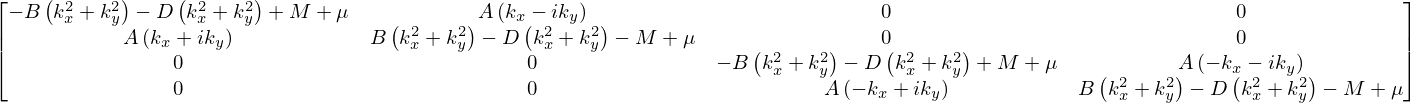

In [2]:
import kwant.continuum

bhz_continuum = '''
    + mu * kron(sigma_0, sigma_0)
    + M * kron(sigma_0, sigma_z)
    - B * (k_x**2 + k_y**2) * kron(sigma_0, sigma_z) - D * (k_x**2 + k_y**2) * kron(sigma_0, sigma_0)
    + A * (k_x * kron(sigma_z, sigma_x) + k_y * kron(sigma_0, sigma_y))
'''
kwant.continuum.sympify(bhz_continuum)  # Not discretized yet; just to see what it looks like

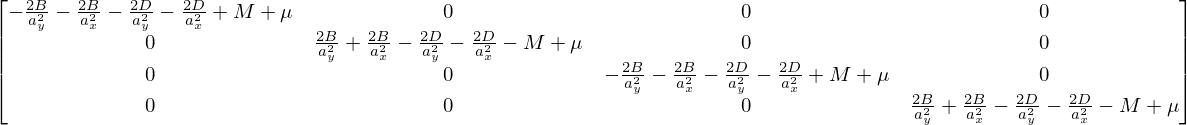

In [3]:
tb_matrix_elements, coords = kwant.continuum.discretize_symbolic(bhz_continuum)
tb_matrix_elements[0, 0]  # onsite

In [4]:
# We can also go straight from continuum model to TB model with 'kwant.continuum.discretize'
bhz_model = kwant.continuum.build_discretized(tb_matrix_elements, coords)
print(bhz_model.lattice.norbs)
print(bhz_model.symmetry.periods) 

4
[[1.0 0.0]
 [0.0 1.0]]


<IPython.core.display.Javascript object>


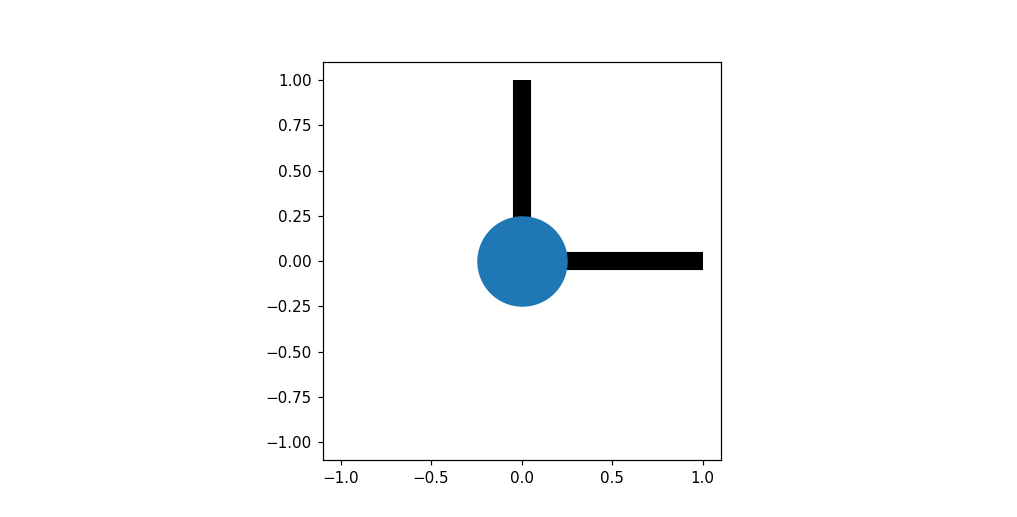

In [5]:
kwant.plot(bhz_model);

# Building the scattering system

<IPython.core.display.Javascript object>


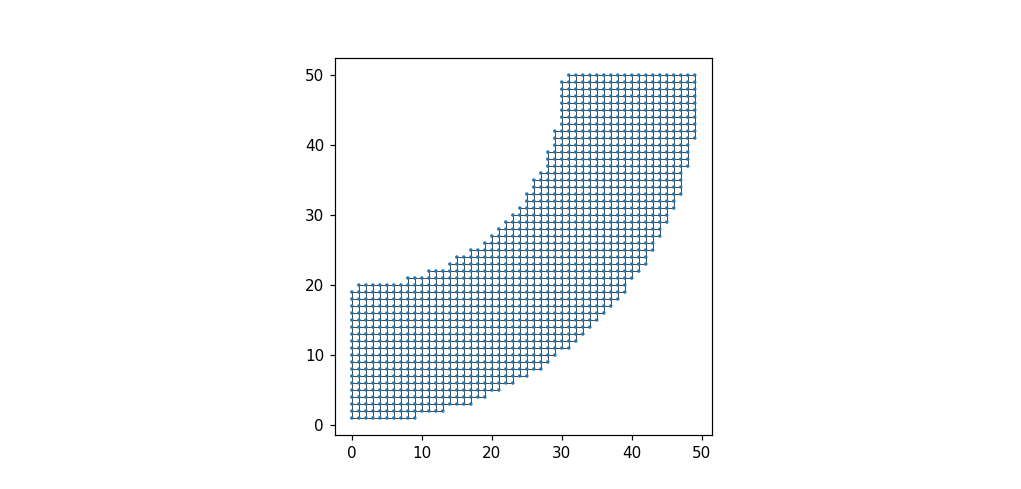

In [6]:
syst = kwant.Builder() # We'll fill this with the TB model of our scattering region

def scattering_region(site):
    x, y = site.tag  # position in integer lattice coordinates
    y = y - 50
    return (30**2 < (x**2 + y**2) < 50**2  # inside a ring
            and (x >= 0 and y <= 0))  # lower-right quadrant ofring

# Fill our scattering region with the BHZ model in a certain region of space
syst.fill(template=bhz_model, shape=scattering_region, start=(0, 10))

kwant.plot(syst);

+ Builder → "this is the object that allows us to construct a tight-binding model"
+ Builders allow you to build tight-binding models in very flexible ways
+ For now we're going to see a feature of Builders that was added to Kwant recently: filling a Builder with a translationally invariant model.

<IPython.core.display.Javascript object>


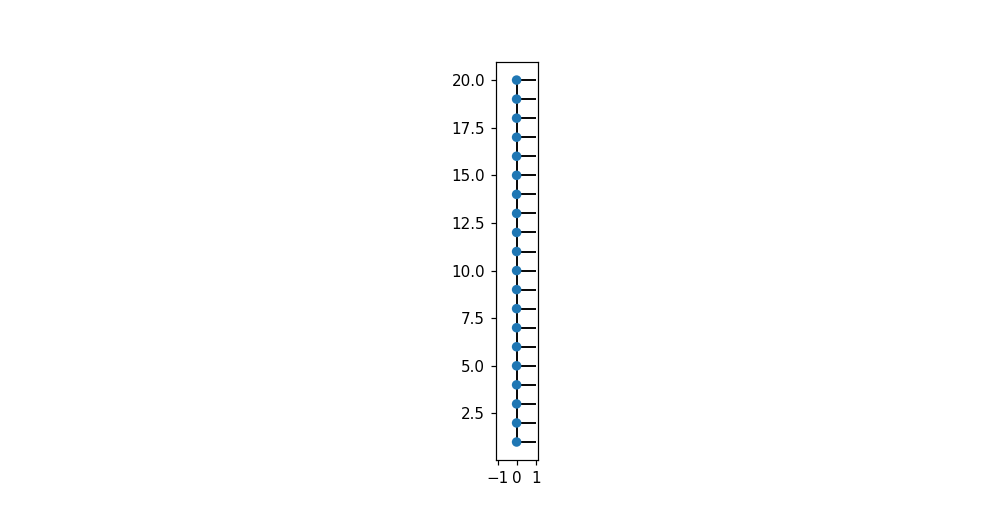

In [7]:
lead_x = kwant.Builder(symmetry=kwant.TranslationalSymmetry((-1, 0)),
                       time_reversal=np.kron(1j * sigma_y, sigma_0),
                       conservation_law=np.kron(-sigma_z, sigma_0),  # spin conservation
                      )

lead_x.fill(bhz_model, lambda site: 1 <= site.tag[1] <= 20, (0, 1))

kwant.plot(lead_x);

+ In order to exploit structure of the problem we should declare the conservation laws and symmetries
+ Qsymm (Varjas et al. https://dx.doi.org/10.1088/1367-2630/aadf67) and its Kwant integration can help here

In [8]:
# Just the same as the x-direction, so we skip this in the slides
lead_y = kwant.Builder(symmetry=kwant.TranslationalSymmetry((0, 1)),
                       time_reversal=np.kron(1j * sigma_y, sigma_0),
                       conservation_law=np.kron(-sigma_z, sigma_0),
                      )

lead_y.fill(bhz_model, lambda site: 30 <= site.tag[0] <= 49, (35, 0));

<IPython.core.display.Javascript object>


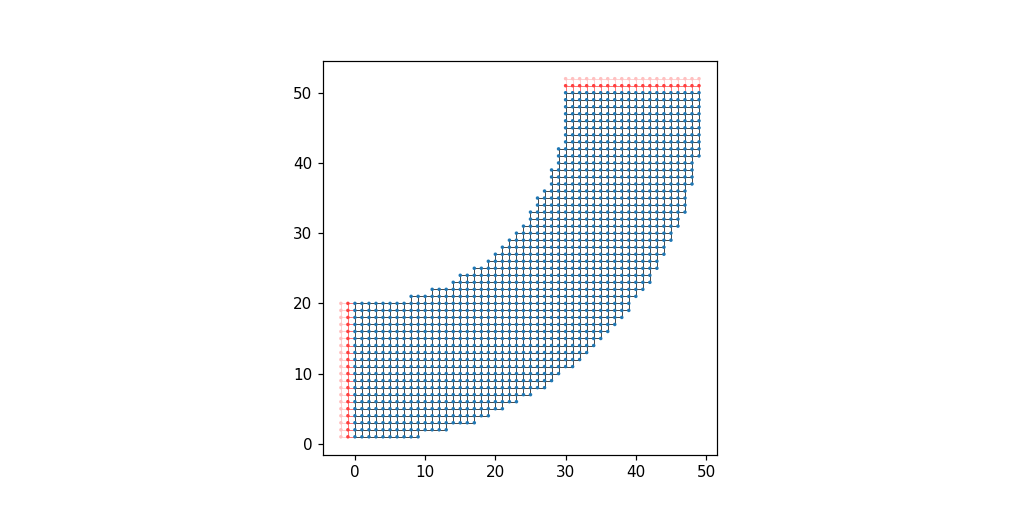

In [9]:
syst.attach_lead(lead_x)
syst.attach_lead(lead_y)

kwant.plot(syst);

In [10]:
fsyst = syst.finalized()  # Transform the system into an efficient form for numerics
print(fsyst)

<FiniteSystem with 1272 sites, 4888 hoppings, and parameters: ('mu', 'D', 'M', 'B', 'A')>


# What did we just do?

*We defined the Hamiltonian of our system as an "infinite matrix"*

<div>
<img src="images/curve-system.png" width=30% style="float: left"></img>
<div style="margin-right: 10%; float:right">
$$
H = 
\begin{pmatrix}
H_s & P^T_s V_l^\dagger & \\
V_lP_s & H_l               & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots
\end{pmatrix}
$$
    
$$\begin{align}
&H_s: \text{Scattering region Hamiltonian} \\
&H_l: \text{Lead(s) unit cell Hamiltonian} \\
&V_l: \text{Lead(s) inter-cell hopping Hamiltonian} \\
\end{align}$$
</div>
</div>

# How do we do transport with this?

1. Solve the Schrödinger equation to find the energy eigenstates
2. Fill the states up according to some prescription
3. Calculate physical observables by summing over contributions from occupied states

*All the formalism I will show is discussed at length in an upcoming review article.*

# Solving Schrödinger equation for an ∞ tight-binding model

1. Solve Schrödinger equation in the leads *first* (using Bloch's theorem)
2. Match the solution in the scattering region

+ add slide with just "title" of next section when we're going to be doing something conceptually different

# Solving the Schrodinger equation in the leads

$$
\begin{pmatrix}
   \ddots &                   &     &       & \\
V_l & H_l & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots \\
\end{pmatrix}
\begin{pmatrix}
⋮ \\ ψ_{-1} \\ ψ_0 \\ ψ_1 \\ ⋮ 
\end{pmatrix}
=
E
\begin{pmatrix}
⋮ \\ ψ_{-1} \\ ψ_0 \\ ψ_1 \\ ⋮ 
\end{pmatrix}
$$

Use Bloch's theorem: $ψ_n = λ^n φ$

$$
\begin{pmatrix}
   \ddots &                   &     &       & \\
V_l & H_l & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots \\
\end{pmatrix}
\begin{pmatrix}
⋮ \\ λ^{-1}φ \\ φ \\ λφ \\ ⋮ 
\end{pmatrix}
=
E
\begin{pmatrix}
⋮ \\ λ^{-1}φ \\ φ \\ λφ \\ ⋮ 
\end{pmatrix}
$$

Each row reduces to the following:

$$
V_l φ + λ(H_l - E)φ + λ^2V_l^\daggerφ = 0
$$

A finite problem that we can solve!

*Given* $E$, what are the corresponding $φ$'s and $λ$'s?

**Quadratic eigenvalue problem in λ: what do?**

write: $ξ \equiv λφ$, then

<br/>

$$
\begin{pmatrix}
H_l - E & V_l^\dagger \\ 1 & 0
\end{pmatrix}
\begin{pmatrix}
φ \\ ξ
\end{pmatrix}
=
λ^{-1}
\begin{pmatrix}
-V_l & 0 \\ 0 & 1
\end{pmatrix}
\begin{pmatrix}
φ \\ ξ
\end{pmatrix}
$$

<br/>

→ Generalized Eigenvalue Problem.

<br/>

Hard to do in stable way; sorting it all out is **the hardest part of Kwant**

<br/>

(If you're feeling brave check out `kwant/physics/leads.py:compute_block_modes` in the Kwant source coode)

+ In Kwant we manually remove the zeros and infinities from the eigenvalues by Using the SVD of V and a Schur decomposition *vigorous waving of hands*.

*propagating* modes: $|λ| = 1$ ; *evanescent* modes: $|λ| \ne 1$

*mode velocity*: $v = iφ^\dagger[λV_l^\dagger - λ^{-1}V_l]φ$

$φ$'s then *normalized* to have unit velocity (current)

Arbitrary state in unit cell $n$:

$$\hat{φ}_n = ΦΛ^nq$$

$$\begin{align}
Φ: &\text{matrix of mode wavefunctions ($φ$'s)} \\
Λ: &\text{diagonal matrix of eigenvalues} \\
q: &\text{column vector of mode amplitudes} \\
\end{align}$$

# Solving the leads with Kwant

## First, the lead dispersion relation

<IPython.core.display.Javascript object>


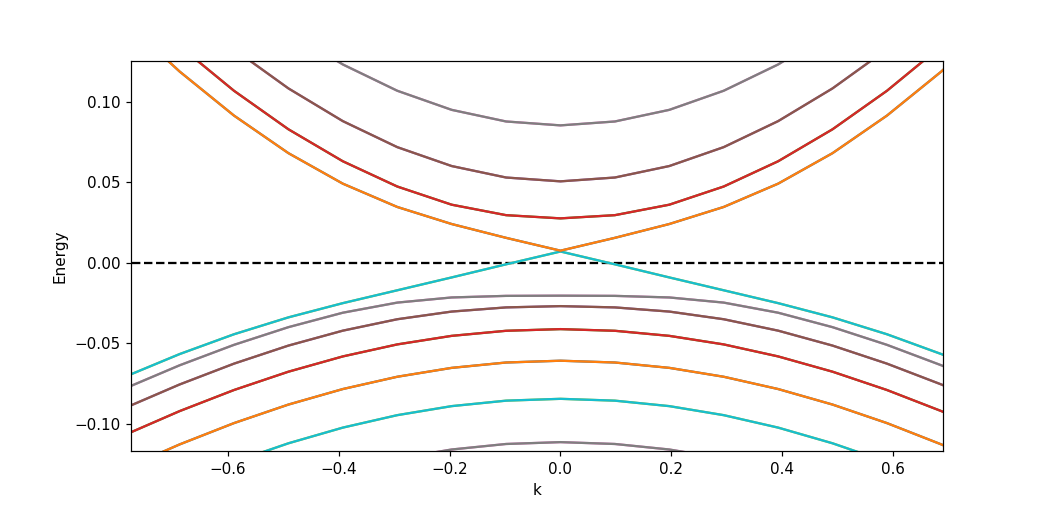

In [11]:
topo_params = dict(A=0.09, B=-0.18, D=-0.065, M=-0.02, mu=0)  # Parameters for topological phase
trivial_params = dict(A=0.09, B=-0.18, D=-0.065, M=0.01, mu=0)  # Parameters for trivial phase

kwant.plotter.bands(fsyst.leads[0], params=topo_params,);
plt.hlines(0, -np.pi, np.pi, linestyles='--');

# Now the modes at $E=0$

In [12]:
propagating_modes, _ = fsyst.leads[0].modes(energy=0, params=topo_params)

print(propagating_modes.wave_functions.shape)
print(propagating_modes.velocities)
print(propagating_modes.momenta)

(80, 4)
[-0.08354984 -0.08354984  0.08354984  0.08354984]
[ 0.08609145  0.08609145 -0.08609145 -0.08609145]


4 propagating modes (2 incoming, 2 outgoing)

Incoming (Outgoing) modes are *degenerate*

In [13]:
# Just a convenience function to 
def plot_densities(*densities, title='Particle'):
    for i, rho in enumerate(densities):     
        plt.plot(rho, 'o-', label='incoming mode ' + str(i))
    plt.title(title + ' density for lead cross-section')
    plt.xlabel('site')
    if title == 'Particle':
        plt.ylabel('$|φ_i|^2$')
    elif title == 'Spin':
        plt.ylabel('$φ_i^\dagger (σ_z ⊗ σ_0) φ_i$')
    plt.legend()

# Visualizing the modes

<IPython.core.display.Javascript object>


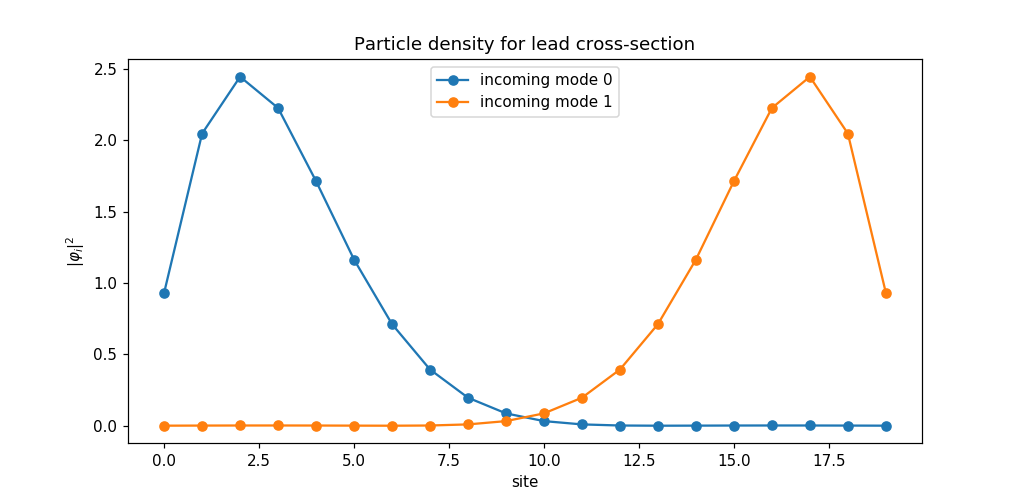

In [14]:
phi0, phi1 = propagating_modes.wave_functions[:, :2].transpose()

density = kwant.operator.Density(fsyst.leads[0]) # calculate |φ_i|**2 for each site (summing degrees of freedom)
density = density.bind(params=topo_params)  # speed up subsequent calculations

plot_densities(density(phi0), density(phi1))

# Visualizing the modes (spin)

<IPython.core.display.Javascript object>


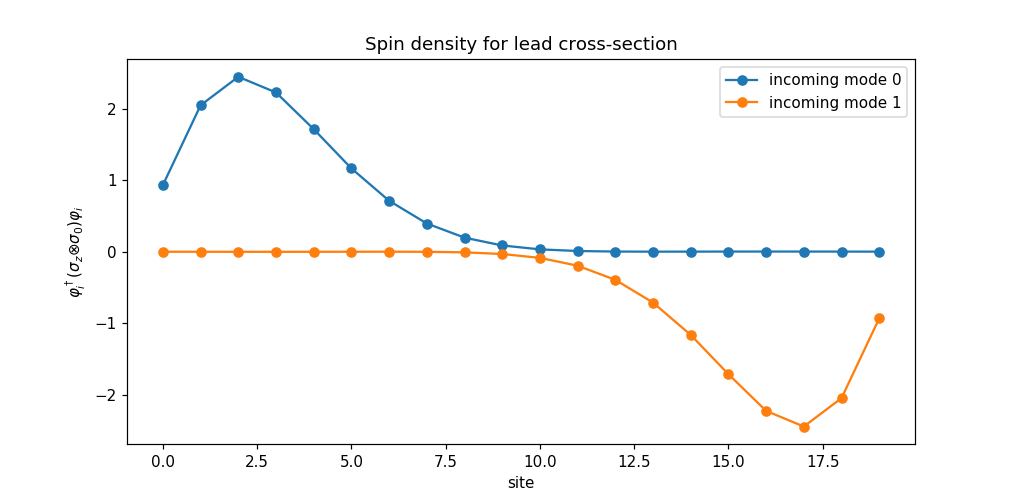

In [15]:
spinz_operator = np.kron(sigma_z, sigma_0)

spin_density = kwant.operator.Density(fsyst.leads[0], spinz_operator)
spin_density = spin_density.bind(params=topo_params)

plot_densities(spin_density(phi0), spin_density(phi1), title='Spin')

+ plot modes to see spin polarisation
+ each of the modes has definite z spin *only* because we declared conservation law. If we had not we would in general have got a linear superposition of spin up and down

# Solving the scattering problem

We still need to solve our original Schrödinger equation:

$$
\begin{pmatrix}
H_s & P^T_s V_l^\dagger & \\
V_lP_s & H_l               & V_l^\dagger \\
    & V_l               & H_l & V_l^\dagger \\
    &                   &     &       & \ddots
\end{pmatrix}
\begin{pmatrix}
ψ_s \\ ψ_1 \\ ψ_2 \\ \vdots
\end{pmatrix}
=
E
\begin{pmatrix}
ψ_s \\ ψ_1 \\ ψ_2 \\ \vdots
\end{pmatrix}
$$

Sub in our mode decomposition in the leads

($Φ_{+}$: *outgoing* modes, $Φ_{p-}$ : *incoming propagating* modes)

$$
\begin{pmatrix}
(H_s - E) & P^T_s V_l^\dagger & \\
V_lP_s & (H_l - E)           & V_l^\dagger \\
    & V_l               & (H_l - E) & V_l^\dagger \\
    &                   &     &       & \ddots
\end{pmatrix}
\begin{pmatrix}
ψ_s \\ Φ_{+}Λ_{+}q_{+} + Φ_{p-}Λ_{p-}q_{p-} \\ Φ_{+}(Λ_{+})^2q_{+} + Φ_{p-}(Λ_{p-})^2q_{p-} \\\vdots
\end{pmatrix}
=
0
$$

Rows 3 onwards are trivially zero → reduces the problem to a finite one

$$
\begin{pmatrix}
(H_s - E) & P^T_s V_l^\dagger Φ_+ Λ_+ & P^T_s V_l^\dagger Φ_{p-} Λ_{p-}\\
V_lP_s & -V_l Φ_+ & -V_l Φ_{p-}\\
\end{pmatrix}
\begin{pmatrix}
ψ_s \\ q_{+} \\ q_{p-}
\end{pmatrix}
=
0
$$

Finding all energy $E$ solutions → finding null space of left-hand side

Ideally we would like a "nice" basis that will make it easy to do physics later

Leads individually in thermal equilibrium → choose basis where *incoming mode occupation* is a good quantum number

In the end we're going to want to fill up the system by populating the states according to the thermal distributions of the leads.

This imposes conditions on the *incoming* occupation numbers.


Set $q_{p-} = \begin{pmatrix} 1, & 0, & …\end{pmatrix}^T$ so that $Φ_{p-}q_{p-} = φ_{-,0}$ and $Φ_{p-}Λ_{p-}q_{p-} = λ_{-,0}φ_{-,0}$

$$
\begin{pmatrix}
(H_s - E) & P^T_s V_l^\dagger Φ_+ Λ_+ \\
V_lP_s & -V_l Φ_+\\
\end{pmatrix}
\begin{pmatrix}
ψ_s \\ \tilde{q}_{+}
\end{pmatrix}
=
\begin{pmatrix}
-P^T_s V_l^\dagger φ_{-,0}\,λ_{-,0} \\
-V_l φ_{-,0}
\end{pmatrix}
$$

Fully determined linear system to solve

$\tilde{q}_{+}$: probability amplitudes for finding the particle in a given outgoing mode, *given that* it was certainly incoming in mode $ζ$.

A set of such linear systems: each injecting particles in a different incoming propagating mode

Stack them together:


$$
\begin{pmatrix}
(H_s - E) & P^T_s V_l^\dagger Φ_+ Λ_+ \\
V_lP_s & -V_l Φ_+\\
\end{pmatrix}
\begin{pmatrix}
Ψ_s \\ Q_{+}
\end{pmatrix}
=
\begin{pmatrix}
-P^T_s V_l^\dagger Φ_{p-}Λ_{p-} \\
-V_l Φ_{p-}
\end{pmatrix}
$$

$Ψ_s$: matrix of **scattering wavefunctions** in the scattering region

$Q_+$: **extended scattering matrix**, outgoing (propagating and evanescent) mode amplitudes

$S$:   **scattering matrix**, submatrix of $Q_+$ that concerns the *propagating modes only*

+ say that kwant is just a nice way of specifying the problem, and an efficient solver (there's no magic)

# How do we calculate current from this?
*Populate the scattering states according to the occupations of the originating leads*

<div style="float: left; max-width: 50%">
    
Transport only in finite "transport window"

---

For 2 leads, in limit $T → 0$ and $V_b → 0$:

$$
I_{L→R} = \underbrace{\frac{e^2}{h} \sum_{α\in L, β \in R} |S_{βα}(E_F)|^2}_{g(E_F)} \; V_b
$$

</div>
<img src="images/transport-sketch.svg" style="width: 50%; float: right"></img>


In [16]:
S = kwant.smatrix(fsyst, energy=0, params=topo_params)

t_10 = S.submatrix(1, 0)  # transmission block, from lead 0 to lead 1

print(t_10)  
print(np.trace(t_10.T.conjugate() @ t_10))  # manually calculate transmission
print(S.transmission(1, 0))  # Kwant has an easy method for this

[[ 0.50308727+0.8642344j   0.        +0.j        ]
 [-0.        +0.j          0.27020161-0.96280267j]]
(1.9999957932536168+0j)
1.9999957932536172


+ Useful to access $S$ directly, e.g. calculate spin current

In [17]:
def prepare_axes(title):
    _, (ax0, ax1) = plt.subplots(1, 2)
    for ax in (ax0, ax1):
        ax.set_xlabel('x')
        ax.set_xlabel('y')
    ax0.set_title(title + ' from left lead')
    ax1.set_title(title + ' from right lead')
    return (ax0, ax1)

In [18]:
scattering_states = kwant.wave_function(fsyst, energy=0, params=topo_params)

sl0, sl1 = scattering_states(0)  # from lead 0
sr0, sr1 = scattering_states(1)  # from lead 1

<IPython.core.display.Javascript object>


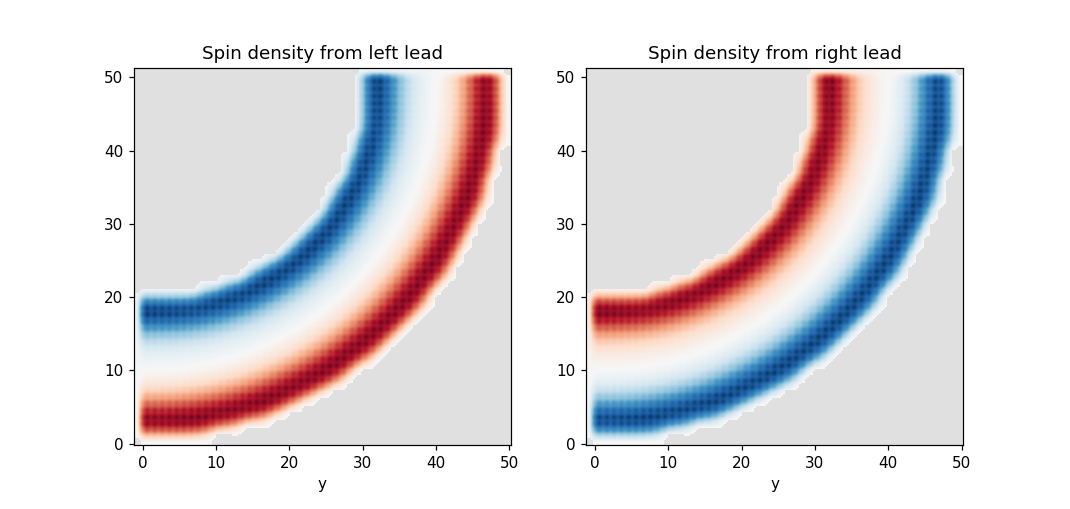

In [19]:
spin_density = kwant.operator.Density(fsyst, spinz_operator).bind(params=topo_params)

(ax0, ax1) = prepare_axes('Spin density')
kwant.plotter.density(fsyst, spin_density(sl0) + spin_density(sl1), cmap='RdBu_r', ax=ax0)
kwant.plotter.density(fsyst, spin_density(sr0) + spin_density(sr1), cmap='RdBu_r', ax=ax1)

<IPython.core.display.Javascript object>


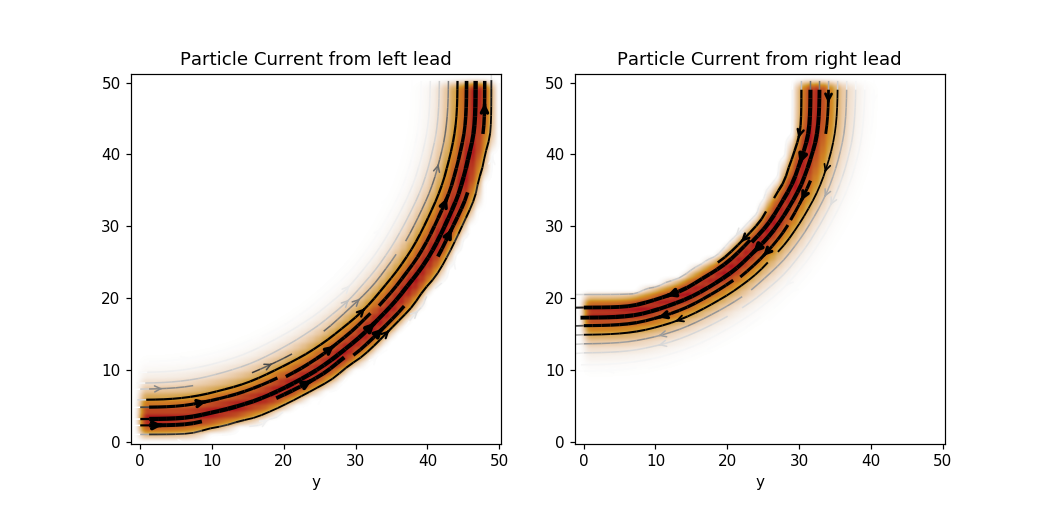

In [20]:
current = kwant.operator.Current(fsyst).bind(params=topo_params)

(ax0, ax1) = prepare_axes('Particle Current');
kwant.plotter.current(fsyst, current(sl0) , ax=ax0)
kwant.plotter.current(fsyst, current(sr0), ax=ax1)

# Let's add some scattering

In [23]:
# Build a fresh system so that it's defined local to  where we're going to eventually
# make our modifications (in case we need to start from scratch)
syst = kwant.Builder()
syst.fill(template=bhz_model, shape=scattering_region, start=(0, 10))

syst.attach_lead(lead_x)
syst.attach_lead(lead_y);

<IPython.core.display.Javascript object>


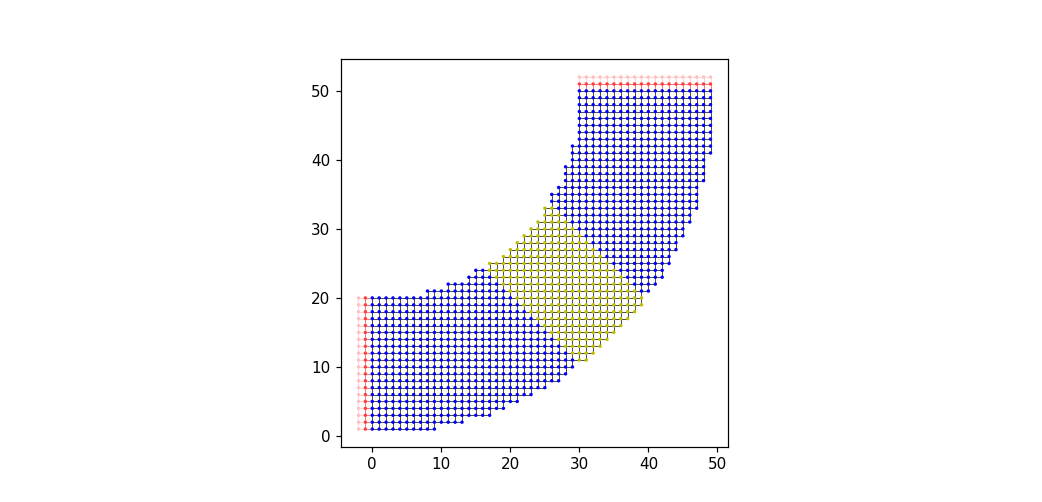

In [21]:
def barrier_region(site):
    x, y = site.tag
    return (scattering_region(site) and 40 < x+y < 60)

del syst[filter(barrier_region, list(syst.sites()))]
syst.fill(bhz_model.substituted(mu='mu_scatter'), barrier_region, (30, 15))
            
kwant.plot(syst, site_color=lambda s: 'y' if barrier_region(s) else 'b');

In [22]:
fsyst = syst.finalized()
print(fsyst)

scatter_params = dict(**topo_params, mu_scatter=0.3)

<FiniteSystem with 1272 sites, 4888 hoppings, and parameters: ('mu', 'D', 'M', 'B', 'mu_scatter', 'A')>


In [23]:
current = kwant.operator.Current(fsyst).bind(params=scatter_params)

scattering_states = kwant.wave_function(fsyst, energy=0, params=scatter_params)

sl0, sl1 = scattering_states(0)  # from lead 0
sr0, sr1 = scattering_states(1)  # from lead 1

<IPython.core.display.Javascript object>


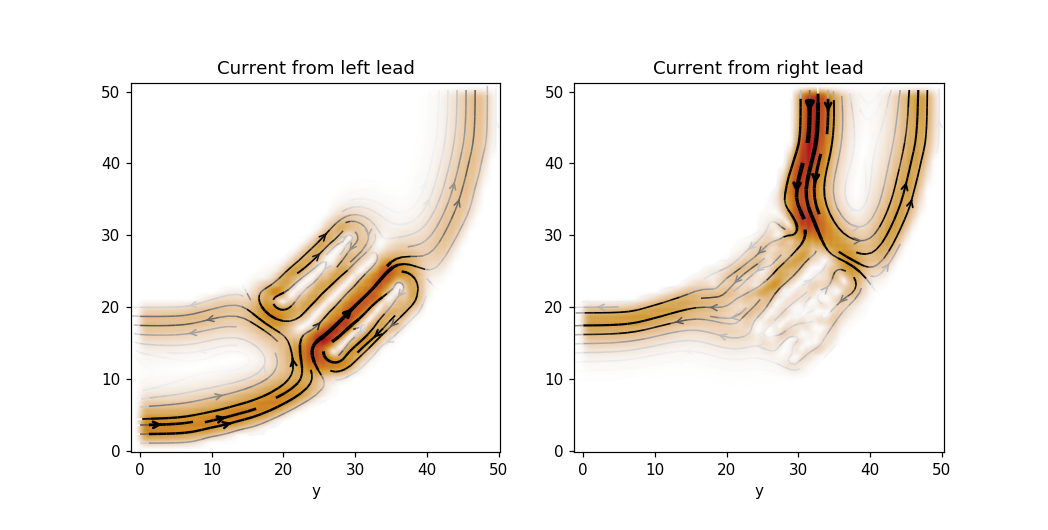

In [24]:
...  # hidden code where we call 'kwant.wave_function' with the new system and parameters
(ax0, ax1) = prepare_axes('Current');
kwant.plotter.current(fsyst, current(sl0), ax=ax0)
kwant.plotter.current(fsyst, current(sr0), ax=ax1)

+ Add some scattering with an impurity + substituted

# Takeaway Points

#### Kwant is *not a black box*
- Kwant "just" solves a generalized eigenvalue problem, and then a linear system!

#### Kwant has powerful features for rapid prototyping
- `kwant.continuum.discretize` for working with continuum models
- `kwant.Builder` for defining geometry and model fine-tuning
- `kwant.smatrix` for global transport properties
- `kwant.operator` for local properties

#### Advanced Kwant users make extensive use of intermediate results
- `kwant.physics.modes` for modes of translationally invariant systems
- `kwant.wave_function` for scattering states

# A gallery of cool features

*That I didn't have time to showcase*

## `kwant.kpm`

<div style="float:left; max-width: 60%">
    
*Kernel Polynomial Method*

+ Large finite systems are expensive to diagonalize
+ KPM → approximate spectral density using Chebyshev expansion and stochastic trace
+ Also "local conductivity" using the Kubo-Bastin formula


```
rho = kwant.operator.Density(fsyst)
ldos = kwant.kpm.spectral_density(fsyst, rho)

kwant.plotter.density(fsyst, ldos(energy=0))
```

---

<footer>

<small>Weiss et al. (2006) [DOI: 10.1103/RevModPhys.78.275](https://dx.doi.org/10.1103/RevModPhys.78.275)
    
García et al. (2014) [DOI: 10.1103/PhysRevLett.114.116602](https://dx.doi.org/10.1103/PhysRevLett.114.116602)</small>

</footer>

</div>
<img style="float: right; max-width: 30%" src="images/penrose_chern_map.png"></img>



# `kwant.qsymm`
*Symmetry analysis for continuum and tight-binding models*

+ Find symmetries of symbolic (continuum) or tight-binding models
+ Generate a parametric family of symmetry-compatible Hamiltonians

```
syst = make_system()
kwant.qsymm.find_builder_symmetries(syst)
```

---

<footer>
    
<small>Varjas et al. (2018) [DOI: 10.1088/1367-2630/aadf67](https://dx.doi.org/10.1088/1367-2630/aadf67)</small>

</footer>

 
# `kwant.physics.magnetic_gauge`

<div style="float: left; max-width: 57%">

*Automatic gauge fixing for orbital magnetic fields*

Fixing gauge for the Peierls substitution is cumbersome in nontrivial cases

```
gauge = kwant.physics.magnetic_gauge(fsyst)

phi, phi_lead = gauge(0.5, 0.1)

kwant.smatrix(fsyst,
              params=dict(phi=phi,
                          phi_lead=phi_lead)
)
```
</div>
<img style="float: right; width=30%" src="images/flux_finding_finite.gif"></img>

# Future work

<div class="row">

+ Bound state solver
+ More general scattering problems (using bulk Green's functions and Dyson's equation)
+ Mean-field electrostatics (important for device design)

<div class="row">
<img src="images/majorana.png" style="display: inline; max-width: 40%;   padding-right: 100px;"> </img>
<img src="images/impurity-scatterer.svg" style="display: inline; max-width: 15%; margin-right: 100px"> </img>
<img src="images/edge-scatterer.svg" style="display: inline; max-width: 15%"> </img>

</div>

---

<footer>

<small>

Istas et al. (2018) [DOI: 10.21468/SciPostPhys.4.5.026](https://doi.org/10.21468/SciPostPhys.4.5.026)

</small>

</footer>

</div>



# Get Kwant now!

Get the freshest release: `conda install -c conda-forge kwant=1.4.0`

Check the website for documentation/more information: http://kwant-project.org

---

# Questions?

Post to the mailing list: kwant-discuss@kwant-project.org

---

# Found a bug? Want to suggest/implement a feature?

Open an issue: http://tiny.cc/kwant-issue

